In [7]:
# for data
from statsmodels.graphics.api import abline_plot
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# for statistical tests
import scipy
import statsmodels.formula.api as smf
import statsmodels.api as sm

# for machine learning
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.ensemble import GradientBoostingClassifier

# for explainer
from lime import lime_tabular

# for date
import datetime

# for HTTP
import requests

In [4]:
def utils_recognize_type(dtf, col, max_cat=20):
    if (dtf[col].dtype == "O") | (dtf[col].nunique() < max_cat):
        return "cat"
    else:
        return "num"


def prepareDtf(dtf):
    dtf.columns = dtf.columns.str.strip()
    cols = ["Bucket", "StartId", "StartName", "EndId", "EndName", "Count"]

    dtf = dtf[cols]
    dtf = dtf[dtf['Bucket'].str.len() == 10]
    dtf = dtf.groupby(["Bucket", "EndId", "EndName"])[
        "Count"].sum().reset_index()

    dtf["DoW"] = dtf["Bucket"].apply(
        lambda bucket: pd.to_datetime(bucket).day_name())

    dtf = dtf.rename(columns={"Count": "Y"})

    return dtf


def printHeatmap(dtf):
    dic_cols = {col: utils_recognize_type(
        dtf, col, max_cat=20) for col in dtf.columns}
    heatmap = dtf.isnull()
    for k, v in dic_cols.items():
        if v == "num":
            heatmap[k] = heatmap[k].apply(lambda x: 0.5 if x is False else 1)
        else:
            heatmap[k] = heatmap[k].apply(lambda x: 0 if x is False else 1)
    sns.heatmap(heatmap, cbar=False).set_title('Dataset Overview')
    plt.show()
    print("\033[1;37;40m Categerocial ",
          "\033[1;30;41m Numeric ", "\033[1;30;47m NaN ")


def showKfoldValidation(model, x_train, y_train):
    scores = []
    cv = model_selection.KFold(n_splits=5, shuffle=True)
    fig = plt.figure()
    i = 1
    for train, test in cv.split(x_train, y_train):
        prediction = model.fit(x_train[train],
                               y_train[train]).predict(x_train[test])
        true = y_train[test]
        score = metrics.r2_score(true, prediction)
        scores.append(score)
        plt.scatter(prediction, true, lw=2, alpha=0.3,
                    label='Fold %d (R2 = %0.2f)' % (i, score))
        i = i+1
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)],
             linestyle='--', lw=2, color='black')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('K-Fold Validation')
    plt.legend()
    plt.show()


def scaleData(dtf, y):
    # scale X
    scalerX = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
    X = scalerX.fit_transform(dtf.drop("Y", axis=1))
    dtf_scaled = pd.DataFrame(X, columns=dtf.drop(
        y, axis=1).columns, index=dtf.index)

    # scale Y
    scalerY = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
    dtf_scaled[y] = scalerY.fit_transform(
        dtf[y].values.reshape(-1, 1))

    return dtf_scaled, scalerX, scalerY


def unscaleData(scalerY, predicted, y_test):
    predicted = scalerY.inverse_transform(
        predicted.reshape(-1, 1)).reshape(-1)
    y_test = scalerY.inverse_transform(
        y_test.reshape(-1, 1)).reshape(-1)
    return predicted, y_test


def printKPI(predicted, y_test):
    print("R2 (explained variance):", round(
        metrics.r2_score(y_test, predicted), 3) * 100, "%")
    print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):",
          round(np.mean(np.abs((y_test-predicted)/predicted)), 3) * 100, "%")
    print("Mean Absolute Error (Σ|y-pred|/n):",
          "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
    print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):",
          "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(Y_test, predicted))))
    print("R2 (explained variance):", round(
        metrics.r2_score(y_test, predicted), 3) * 100, "%")
    print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):",
          round(np.mean(np.abs((y_test-predicted)/predicted)), 3) * 100, "%")
    print("Mean Absolute Error (Σ|y-pred|/n):",
          "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
    print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):",
          "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, predicted))))


def computeResiduals(predicted, y_test):
    residuals = y_test - predicted
    max_error = max(residuals) if abs(max(residuals)) > abs(
        min(residuals)) else min(residuals)
    max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(
        min(residuals)) else list(residuals).index(min(residuals))
    max_true, max_pred = y_test[max_idx], predicted[max_idx]
    print("Max Error:", "{:,.0f}".format(max_error))
    return residuals, max_error, max_idx, max_true, max_pred


def plotPredictionKPI(predicted, y_test, max_error, max_true, max_pred):
    # Plot predicted vs true
    fig, ax = plt.subplots(nrows=1, ncols=2)
    ax[0].scatter(predicted, Y_test, color="black")
    abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
    ax[0].vlines(x=max_pred, ymin=max_true, ymax=max_true-max_error,
                 color='red', linestyle='--', alpha=0.7, label="max error")
    ax[0].grid(True)
    ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
    ax[0].legend()

    # Plot predicted vs residuals
    ax[1].scatter(predicted, residuals, color="red")
    ax[1].vlines(x=max_pred, ymin=0, ymax=max_error, color='black',
                 linestyle='--', alpha=0.7, label="max error")
    ax[1].grid(True)
    ax[1].set(xlabel="Predicted", ylabel="Residuals",
              title="Predicted vs Residuals")
    ax[1].hlines(y=0, xmin=np.min(predicted), xmax=np.max(predicted))
    ax[1].legend()
    plt.show()


def plotResidualDistribution(residuals):
    fig, ax = plt.subplots()
    sns.distplot(residuals, color="red", hist=True,
                 kde=True, kde_kws={"shade": True}, ax=ax)
    ax.grid(True)
    ax.set(yticks=[], yticklabels=[], title="Residuals distribution")
    plt.show()


def getHolidays(year):
    # Request free days from Feiertage API for year 2021 in bavaria
    free_days = requests.get(
        f'https://feiertage-api.de/api/?jahr={year}&nur_land=BY')

    # Parse result and store as [key, val] dict
    free_days = free_days.json()

    free_day_dates = []

    # Iterate over
    for free_day_name in free_days:
        free_day_dates.append(free_days[free_day_name]['datum'])

    return free_day_dates

In [5]:
dtf = pd.read_csv("mobilityDataAllgau.csv")

dtf = prepareDtf(dtf)

dtf.head()

       Bucket    EndId                 EndName   Y        DoW
0  2020-01-01  2701400     Schleswig-Flensburg  90  Wednesday
1  2020-01-01  2701700   Rendsburg-Eckernförde  16  Wednesday
2  2020-01-01  2702100                    Kiel  11  Wednesday
3  2020-01-01  2702500             Ostholstein   7  Wednesday
4  2020-01-01  2702702  Lübeck - Sankt Gertrud   6  Wednesday


In [8]:
# define clusters (workingday/weekend)
x = "Day"
Day_clusters = {"free": ["Saturday", "Sunday"], "work": ["Monday", "Tuesday", "Wednesday",
                                                         "Thursday", "Friday"]}
# create DoW_class columns
dic_flat = {v: k for k, lst in Day_clusters.items() for v in lst}
for k, v in Day_clusters.items():
    if len(v) == 0:
        residual_class = k
dtf[x+"_class"] = dtf['DoW'].apply(lambda x: dic_flat[x] if x in
                                   dic_flat.keys() else residual_class)

# create dummies DoW_class
dummy = pd.get_dummies(dtf["Day_class"],
                       prefix="Day_class", drop_first=True)
dtf = pd.concat([dtf, dummy], axis=1)
# holidays = getHolidays(dtf['Bucket'].iloc(0)[:4])
holidays = getHolidays('2020')
for day in holidays:
    dtf.loc[(dtf.Bucket == day), 'Day_class_work'] = 0
    # dtf[dtf['Bucket'] == day]['Day_class_work'] = 0
# drop the original categorical column
dtf = dtf.drop("Day_class", axis=1)

dtf.head


# create dummies DoW
dummy = pd.get_dummies(dtf["DoW"],
                       prefix="DoW", drop_first=False)
dtf = pd.concat([dtf, dummy], axis=1)
# drop the original categorical column
dtf = dtf.drop("DoW", axis=1)


# create dummes EndId
dummy = pd.get_dummies(dtf["EndId"],
                       prefix="EndId", drop_first=False)
dtf = pd.concat([dtf, dummy], axis=1)
# drop the original categorical column
# dtf = dtf.drop("EndId", axis=1)

# # Fill missing data
# dtf["LotFrontage"].fillna(
#     dtf["LotFrontage"].mean())
dtf.head(50)

,Bucket,EndId,EndName,Y,Day_class_work,Day_class_work,DoW_Friday,DoW_Monday,DoW_Saturday,DoW_Sunday,...,EndId_280639000,EndId_280662300,EndId_280877400,EndId_281285000,EndId_281285100,EndId_281285200,EndId_667985900,EndId_667985901,EndId_667985902,EndId_667985903
0,2020-01-01,2701400,Schleswig-Flensburg,90,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-01,2701700,Rendsburg-Eckernförde,16,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-01,2702100,Kiel,11,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-01,2702500,Ostholstein,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-01,2702702,Lübeck - Sankt Gertrud,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2020-01-01,2702800,Dithmarschen,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,2020-01-01,5874500,Wesel - Kreis Wesel,121,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,2020-01-01,6233900,Saale-Orla-Kreis,18,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2020-01-01,6234000,Baden-Baden,43,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,2020-01-01,6234300,Rheinisch-Bergischer Kreis,169,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# define training and test features
DoWColumns = [col for col in dtf if col.startswith('DoW_')]
DayColumns = [col for col in dtf if col.startswith('Day_')]
EndIdColumns = [col for col in dtf if col.startswith('EndId_')]
X_names = DoWColumns + DayColumns + EndIdColumns

relevantDtf = dtf[X_names + ["Y"]]
dtf_scaled, scalerX, scalerY = scaleData(relevantDtf, "Y")

# split data
dtfTrain, dtfTest = model_selection.train_test_split(dtf_scaled,
                                                     test_size=0.3)

X_train = dtfTrain[X_names].values
Y_train = dtfTrain["Y"].values
X_test = dtfTest[X_names].values
Y_test = dtfTest["Y"].values

In [10]:
# call model
# model = linear_model.LinearRegression()
model = ensemble.GradientBoostingRegressor()

# showKfoldValidation(model, X_train, Y_train)

# train
model.fit(X_train, Y_train)
# test
predicted = model.predict(X_test)
# unscale data to compare with actual data
predicted, Y_test = unscaleData(scalerY, predicted, Y_test)

R2 (explained variance): 94.1 %
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 91.0 %
Mean Absolute Error (Σ|y-pred|/n): 1,551
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 10,396
R2 (explained variance): 94.1 %
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 91.0 %
Mean Absolute Error (Σ|y-pred|/n): 1,551
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 10,396
Max Error: -335,445


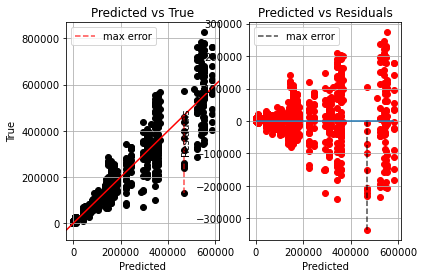

In [11]:
printKPI(predicted, Y_test)

# residuals
residuals, max_error, max_idx, max_true, max_pred = computeResiduals(
    predicted, Y_test)


plotPredictionKPI(predicted, Y_test, max_error, max_true, max_pred)